# GULP Calculations

The `gulp.single` (for single point energy calculations) and `gulp.optimize` (for geometry optimisation calculations) plugins will run the [General Utility Lattice Program (GULP)](http://gulp.curtin.edu.au/gulp/).
They are designed to create the input `.gin` file,
from a set of AiiDA :py:class:`~aiida.orm.nodes.data.Data` nodes.

.. note::

    It is likely that these calculations will eventually be moved to a separate repository.

## Initial Setup

To run a computation, first ensure AiiDA is running:

In [1]:
!verdi status

 ✓ profile:     On profile test_v1_1
 ✓ repository:  /Users/cjs14/GitHub/aiida-crystal17/databases/aiida/test_v1_1
 ✓ postgres:    Connected to cjs14@None:5432
 ✓ rabbitmq:    Connected to amqp://127.0.0.1?heartbeat=600
 ✓ daemon:      Daemon is running as PID 27187 since 2019-04-20 13:47:33


.. seealso::

    AiiDA documentation: :ref:`aiida:quick_installation`

If `aiida-crystal17` is installed,
the `gulp.single` and `gulp.optimize` computations should be available:

In [3]:
!verdi plugin list aiida.calculations gulp.single

Inputs
           code:  required  Code           The Code to use for this job.
      potential:  required  Dict           parameters to create the potential section of the .gin file content.
      structure:  required  StructureData  atomic structure used to create the geometry section of .gin file content.
       metadata:  optional                 
     parameters:  optional  Dict           additional input parameters to create the .gin file content.
Outputs
  remote_folder:  required  RemoteData     Input files necessary to run the process will be stored in this folder node ...
        results:  required  Dict           the data extracted from the main output file
      retrieved:  required  FolderData     Files that are retrieved by the daemon will be stored in this node. By defa ...
Exit codes
             10:  The process returned an invalid output
             11:  The process did not register a required output
            130:  The retrieved folder data node could not be acces

In [4]:
!verdi plugin list aiida.calculations gulp.optimize

Inputs
           code:  required  Code           The Code to use for this job.
      potential:  required  Dict           parameters to create the potential section of the .gin file content.
      structure:  required  StructureData  atomic structure used to create the geometry section of .gin file content.
       metadata:  optional                 
     parameters:  optional  Dict           additional input parameters to create the .gin file content.
       symmetry:  optional  Dict           parameters to create the symmetry section of the .gin file content (for con ...
Outputs
  remote_folder:  required  RemoteData     Input files necessary to run the process will be stored in this folder node ...
        results:  required  Dict           the data extracted from the main output file
      retrieved:  required  FolderData     Files that are retrieved by the daemon will be stored in this node. By defa ...
      structure:  required  StructureData  the optimized structure output fro

To use the python interface,
first ensure a profile is loaded in the python kernel,
and import the required modules:

In [1]:
from aiida import load_profile
profile = load_profile()
profile.name

'fes_db_1b3'

In [2]:
import os
from aiida.orm import Code
from aiida.plugins import (
    DataFactory, WorkflowFactory, CalculationFactory)
from aiida.engine import run_get_node
from aiida_crystal17.common import display_json
from aiida_crystal17.tests import TEST_FILES
from aiida_crystal17.graph import Graph
from jsonextended import edict

## Input Node Creation

.. seealso::

    [GULP Help File](http://gulp.curtin.edu.au/gulp/help/help_45_txt.html)

### Code

.. seealso::

    AiiDA documentation: :ref:`aiida:setup_code`

An :py:class:aiida.orm.nodes.data.code.Code node should be set up in advance, to use the gulp calculation plugin, and call the gulp executable (or mock_gulp used here for test purposes).

In [3]:
from aiida_crystal17.tests.utils import get_or_create_local_computer, get_or_create_code
computer = get_or_create_local_computer('work_directory', 'localhost')
code_single = get_or_create_code('gulp.single', computer, 'mock_gulp')
code_opt = get_or_create_code('gulp.optimize', computer, 'mock_gulp')
code_opt.get_full_text_info()

[['PK', 957],
 ['UUID', '35ebb01d-b4d8-4fe7-a4d9-738e95be8566'],
 ['Label', 'gulp.optimize-mock_gulp@localhost'],
 ['Description', ''],
 ['Default plugin', 'gulp.optimize'],
 ['Type', 'remote'],
 ['Remote machine', 'localhost'],
 ['Remote absolute path', '//anaconda/envs/aiida-workshop/bin/mock_gulp'],
 ['Prepend text', 'No prepend text'],
 ['Append text', 'No append text']]

.. note::

    The calculations are tested against GULP v4.5.3

### Atomic Structure

The ``structure`` refers to a standard
:py:class:`~aiida.StructureData` node, and is used to create the `main.gui`.

Structures consist of:

- A cell with a basis vectors and whether it is periodic, for each dimension
- ``Site`` with a cartesian coordinate and reference to a kind
- ``Kind`` which details the species and composition at one or more sites

The simplest way to create a structure is *via* :py:mod:`ase`:

In [20]:
from ase.spacegroup import crystal
atoms = crystal(
    symbols=[12, 8],
    basis=[[0, 0, 0], [0.5, 0.5, 0.5]],
    spacegroup=225,
    cellpar=[4.21, 4.21, 4.21, 90, 90, 90])
struct_cls = DataFactory('structure')
structure = struct_cls(ase=atoms)
structure

<StructureData: uuid: 379d420a-4b77-480e-a431-4e0f00b59cfb (unstored)>

These structures can be visualised using standard ASE methods.

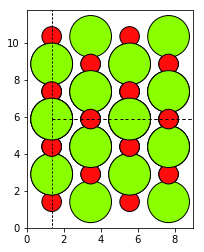

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
atoms = structure.get_ase()
fig, ax = plt.subplots()
plot_atoms(atoms.repeat((2,2,2)), 
           ax, radii=0.8, show_unit_cell=True, 
           rotation=('45x,0y,0z'));

As default, one kind is created per atomic species
(named as the atomic symbol):

In [22]:
structure.get_site_kindnames()

['Mg', 'Mg', 'Mg', 'Mg', 'O1', 'O1', 'O1', 'O1']

However, we may want to specify more than one kind per species (for example to setup anti-ferromagnetic spin). We can achieve this by tagging the atoms:

In [23]:
atoms_afm = atoms.copy()
atoms_afm.set_tags([1, 1, 2, 2, 0, 0, 0, 0])
structure_afm = struct_cls(ase=atoms_afm)
structure_afm.get_site_kindnames()

['Mg1', 'Mg1', 'Mg2', 'Mg2', 'O', 'O', 'O', 'O']

### Inter-Atomic Potential

Inter-atomic potentials are supplied in the form of a py:class:`~aiida.orm.nodes.data.dict.Dict` node with keys `pair_style` and `data`, with the form of the `data` dictated by the pair_style.
Pair styles are created by sub-classing :py:class:`~aiida_crystal17.gulp.potentials.base.PotentialWriterAbstract` and adding an entry point to `gulp.potentials`. Available pair styles and data schema can be found by:

In [32]:
!verdi data gulp.potentials list

Registered entry points for gulp.potentials:
* lj
* reaxff

Info: Pass the entry point as an argument to display detailed information


In [44]:
!verdi data gulp.potentials list lj -d 8

Lennard-Jones potential
Data Schema:
$schema:     http://json-schema.org/draft-07/schema
additionalProperties: False
description: schema for creating GULP lennard-jones potential: E = A/r**m -
             B/r**n
properties:  
  atoms: 
    additionalProperties: False
    description: mapping or atomic symbols to parameters, e.g. 'H': {'H': {...}}
    patternProperties: 
      [A-Z][a-z]?: 
        additionalProperties: False
        patternProperties: 
          [A-Z][a-z]?: 
            properties: 
              A: {...}
              B: {...}
              rmax: {...}
              rmin: {...}
            required: [A, B, rmax]
            type: object
        type:        object
    type:        object
  m: 
    default: 12
    description: first exponent
    exclusiveMinimum: 0
    type:    integer
  n: 
    default: 6
    description: second exponent
    exclusiveMinimum: 0
    type:    integer
required:    [atoms]
type:        object


In [7]:
from aiida.plugins import load_entry_point
writer = load_entry_point('gulp.potentials', 'lj')()
data = {
        "atoms": {
            "H": {
                "He": {
                    "A": 1.0,
                    "B": 2.0,
                    "rmax": 12.0
                }
            }
        }
    }
print(writer.create_string(data))

lennard 12 6
H He 1.0 2.0 12.0


ReaxFF data can be created from the standard LAMMPS style potential file, using

In [28]:
from aiida_crystal17.tests import TEST_FILES
from aiida_crystal17.gulp.potentials.reaxff import (
    read_reaxff_file)

data = read_reaxff_file(os.path.join(TEST_FILES, 'gulp', 'in', 'FeCrOSCH.reaxff'))
edict.pprint(data, depth=1, keycolor='blue')

angles: {...}
bonds: {...}
descript: Reactive MD-force field: Cr/O/Fe/S/C/H force field 2014
hbonds: {...}
off-diagonals: {...}
params: {...}
species: {...}
tolerances: {...}
torsions: {...}


## Setting Up and Running the Calculations

.. seealso::

    AiiDA documentation: :ref:`aiida:working_processes`

In [11]:
from aiida_crystal17.symmetry import convert_structure
structure_data = {
    "lattice": [[5.38, 0.000000, 0.000000],
                [0.000000, 5.38, 0.000000],
                [0.000000, 0.000000, 5.38]],
    "fcoords": [[0.0, 0.0, 0.0], [0.5, 0.0, 0.5], [0.0, 0.5, 0.5],
                [0.5, 0.5, 0.0], [0.338, 0.338, 0.338],
                [0.662, 0.662, 0.662], [0.162, 0.662, 0.838],
                [0.838, 0.338, 0.162], [0.662, 0.838, 0.162],
                [0.338, 0.162, 0.838], [0.838, 0.162, 0.662],
                [0.162, 0.838, 0.338]],
    "symbols": ['Fe'] * 4 + ['S'] * 8,
    "pbc": [True, True, True]
}
structure = convert_structure(structure_data, "aiida")
structure

<StructureData: uuid: d5834436-c69d-42ce-8b24-932a86f5d7b2 (unstored)>

In [12]:
potential_data = {
    "pair_style": "lj",
    "data": {
        "atoms": {
            "Fe": {
                "Fe": {
                    "A": 1.0,
                    "B": 1.0,
                    "rmax": 12.0
                },
                "S": {
                    "A": 1.0,
                    "B": 1.0,
                    "rmax": 12.0
                }
            },
            "S": {
                "S": {
                    "A": 1.0,
                    "B": 1.0,
                    "rmax": 12.0
                }
            }
        }
    }
}
potential_lj = DataFactory('dict')(dict=potential_data)
potential_lj

<Dict: uuid: f84d7fb2-19d0-407a-a0e5-7b921e305a61 (unstored)>

### gulp.single

In [20]:
code_single = Code.objects.get(
    label="gulp.single-mock_gulp@localhost")
builder = code_single.get_builder()
builder.metadata.options = {
    "resources": {
        "num_machines": 1, 
        "num_mpiprocs_per_machine": 1}}
builder.structure = structure
builder.potential = potential_lj

<CalcJobNode: uuid: 0a9f0f7f-3c34-40fd-93d8-09f2db6d35cb (pk: 468) (aiida.calculations:gulp.single)>

In [ ]:
result, calcnode = run_get_node(builder)
calcnode

In [21]:
print(calcnode.is_finished_ok)
print(calcnode.process_state)
print(calcnode.exit_status)

True
ProcessState.FINISHED
0


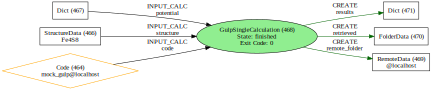

In [22]:
from aiida_crystal17.graph import Graph
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calcnode)
graph.add_incoming(calcnode, annotate_links="both")
graph.add_outgoing(calcnode, annotate_links="both")
graph.graphviz

### gulp.optimize

In [30]:
opt_dict={
    "minimize": {"style": "cg", "max_iterations": 100},
    "relax": {"type": "conp"}}
opt_params = DataFactory('dict')(dict=opt_dict)
opt_params

<Dict: uuid: 902f4058-8ac4-4816-8a77-648518d4bb0e (unstored)>

In [35]:
code_opt = Code.objects.get(
    label="gulp.optimize-mock_gulp@localhost")
builder_opt = code_opt.get_builder()
builder_opt.metadata.options = {
    "resources": {
        "num_machines": 1, 
        "num_mpiprocs_per_machine": 1}}
builder_opt.structure = structure
builder_opt.potential = potential_lj
builder_opt.parameters = opt_params

In [36]:
result, calcnode_opt = run_get_node(builder_opt)
calcnode_opt

//anaconda/envs/aiida-workshop/lib/python3.6/site-packages/ase/io/cif.py:321: UserWarning: crystal system 'triclinic' is not interpreated for space group 1. This may result in wrong setting!
  setting_name, spacegroup))


<CalcJobNode: uuid: 5b245ba7-36b4-4c44-a0e8-4a3da4625e45 (pk: 478) (aiida.calculations:gulp.optimize)>

In [37]:
print(calcnode_opt.is_finished_ok)
print(calcnode_opt.process_state)
print(calcnode_opt.exit_status)

True
ProcessState.FINISHED
0


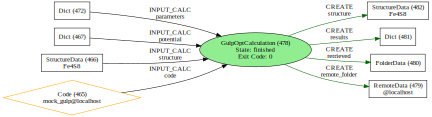

In [38]:
from aiida_crystal17.graph import Graph
graph = Graph(graph_attr={'size': "6,8!", "rankdir": "LR"})
graph.add_node(calcnode_opt)
graph.add_incoming(calcnode_opt, annotate_links="both")
graph.add_outgoing(calcnode_opt, annotate_links="both")
graph.graphviz

In [40]:
display_json(calcnode_opt.outputs.results.attributes)

```json
{
  "energy": -17.47113113,
  "energy_initial": -0.32809466,
  "optimised": true,
  "energy_units": "eV",
  "errors": [],
  "warnings": [],
  "parser_warnings": [],
  "parser_errors": [],
  "parser_class": "GulpOptParser",
  "parser_version": "0.5.0b2"
}
```